In the [2018 Data Sciene Bowl](https://www.kaggle.com/c/data-science-bowl-2018), a Kaggle competition, the competitors were provided with microscopic images of nuclei and were tasked to identify them. In this notebook, we will explore the data and experiment a baseline model.

Thanks Kjetil Åmdal-Sævik for [his notebook](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) and Raoul Malm for [his](https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352).

# 1. Data Exploration

## 1.1 Load Data

In [1]:
from project_utils import load_train_set

TRAIN_PATH = 'data/train/'

train = load_train_set(TRAIN_PATH)

Loading images...


100%|██████████| 670/670 [00:02<00:00, 295.69it/s]


Loading masks...


100%|██████████| 670/670 [00:20<00:00, 32.34it/s]


In [2]:
from project_utils import load_test_set

TEST_PATH = 'data/test/'

test = load_test_set(TEST_PATH)

Loading images...


100%|██████████| 65/65 [00:00<00:00, 253.67it/s]


## 1.2 Sample Data

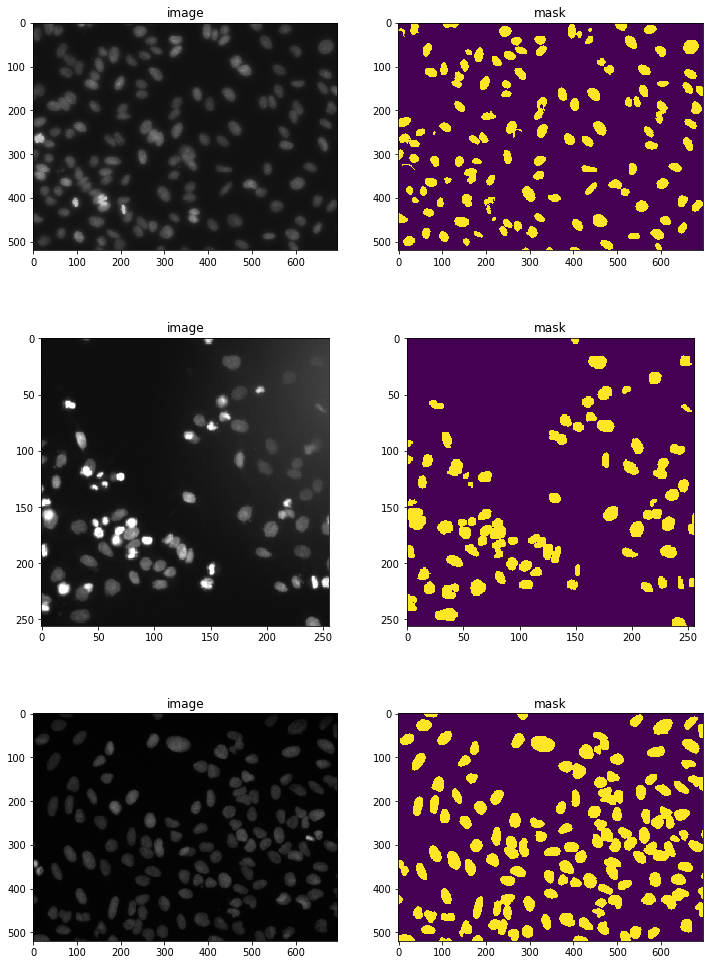

In [3]:
from project_utils import compare_images

compare_images(train['image'], train['mask'], title1='image', title2='mask')

It is noteworthy that some nuclei in the border region are cropped. It is possible that this would confuse the model. Padding, by mirroing or other ways, might help.

## 1.3 Image Dimension
The images have different dimension. Before we decide how to handle it, first let's take a look at the statstic.

### 1.3.1 Train set

In [4]:
from project_utils import get_dim_stat

train_dim_stat = get_dim_stat(train['image'])
train_dim_stat.describe()

,height,width,h/w ratio,channel count
count,670.000000,670.000000,670.000000,670.0
mean,333.991045,378.500000,0.921008,4.0
std,149.474845,204.838693,0.114294,0.0
min,256.000000,256.000000,0.474057,4.0
25%,256.000000,256.000000,0.800000,4.0
50%,256.000000,320.000000,1.000000,4.0
75%,360.000000,360.000000,1.000000,4.0
max,1040.000000,1388.000000,1.000000,4.0


### 1.3.2 Test set

In [5]:
test_dim_stat = get_dim_stat(test['image'])
test_dim_stat.describe()

,height,width,h/w ratio,channel count
count,65.000000,65.000000,65.000000,65.000000
mean,402.676923,393.184615,1.186171,3.569231
std,129.082956,189.813386,0.631035,0.499038
min,256.000000,161.000000,0.747126,3.000000
25%,256.000000,256.000000,0.800000,3.000000
50%,512.000000,256.000000,1.000000,4.000000
75%,519.000000,640.000000,1.494253,4.000000
max,524.000000,696.000000,3.223602,4.000000


### 1.3.3 Insight
It appears that most samples, from both the train set and the test set, are 256x256. Most of those that are not are larger, with only a few exceptions in the test set. It should not be a problem to scale these larger ones down. The height/width ratio could be a problem, however. Some images from the test set have extremely uneven height and width, so resizing them to a square shape would significantly deform the image. It is unclear to me at this point how much would it affect the performance.   

# 2. Preprocessing

## 2.1 Generalization
In order to be used as input for the model, the images must have the same size. There might be better methods, but at this stage we will simply resize the images to have 256x256 pixels. 
Many of the images are black and white whereas some are colored. We assume that color should not play any role in the detection process, and standardize the images by converting them all to grayscale.

In [6]:
from project_utils import standardize_images

shape = (256, 256)

X = standardize_images(train['image'], shape=shape, grayscale=True)
Y = standardize_images(train['mask'], shape=shape, grayscale=True)
X_ = standardize_images(test['image'], shape=shape, grayscale=True)

Sample original images vs transformed images

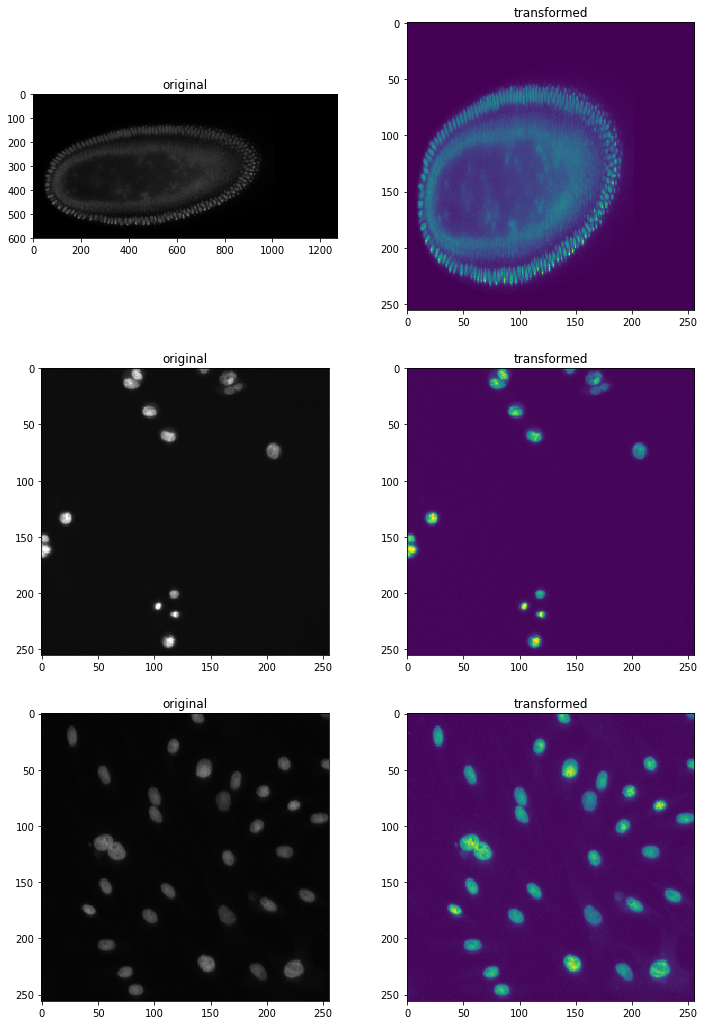

In [7]:
compare_images(train['image'], X, title1='original', title2='transformed')

## 2.2 Data Augmentation
It is very common to use a convolutional neural network (CNN) for image data, and many studies have shown that CNNs is sensitive to the rotation, tilt, and other forms of deformation. To solve this problem, we could try adding transformed copies of the images to the train set.  

In [8]:
from project_utils import augment_data

X, Y = augment_data(X, Y, rotate=True)
print("%d samples added (total %d)" % (X.shape[0]-train.shape[0], X.shape[0]))

670 samples added (total 1340)


# 3. Evaluation Metric
The competition evaluates a submission by calculating the average of intersection over union (IoU) with different threshold (0.5 to 0.95, with a step size of 0.05). Keras does not support this as evaluation metric; TensorFlow supports mean IoU metric but not over multiple thresholds; therefore, we need to write our own.

In [9]:
import keras.backend as K
import tensorflow as tf


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

c:\users\chuanli\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
